In [16]:
import langgraph
from langgraph.graph import StateGraph
from typing import Dict, TypedDict
from langgraph.graph import Graph, START, END
from typing import Literal

In [40]:
# Define the state schema
class ChatState(TypedDict, total=False):
    input: str
    response: str
    guardrails_response: str
    evaluation: str

def guardrails_check(state: ChatState) -> ChatState:
    """Checks if the input string passes the guardrails."""
    user_input = state["input"]
    if "steal" in user_input.lower():  # Simple example check
        state['guardrails_response'] = "failed"
        state['response'] = "I'm sorry, but I cannot process this request."
    return state  # Pass to next node

def agent_actions(state: ChatState) -> ChatState:
    """Simulates agent processing the input."""
    user_input = state["input"]
    response = f"Processed response to: {user_input}, the plan platinum unlimited is the best one month plan with highest features and capabilities."
    state["response"] = response
    return state

def evaluator(state: ChatState) -> ChatState:
    """Evaluates if the agent's response is satisfactory."""
    response = state.get("response", "")  # Avoid KeyError
    if "platinum unlimited" in response.lower():
        state["evaluation"] = "Response seems appropriate."
    else:
        state["evaluation"] = "Response may not be relevant."
    return state

In [41]:
# Define the LangGraph workflow
graph = StateGraph(ChatState)

graph.add_node("guardrails", guardrails_check)
graph.add_node("agent", agent_actions)
graph.add_node("evaluator", evaluator)
graph.add_node("END", lambda state: state)  # Terminal node

def guardrails_to_agent(state: ChatState) -> Literal["END", "agent"]:
    return "agent" if state.get('guardrails_response') != "failed" else "END"

graph.add_conditional_edges("guardrails", guardrails_to_agent)
graph.add_edge("agent", "evaluator")
graph.add_edge("evaluator", "END")

graph.set_entry_point("guardrails")
workflow = graph.compile()


In [42]:
# Visualize your graph
from IPython.display import Image, display
png = workflow.get_graph().draw_mermaid_png()

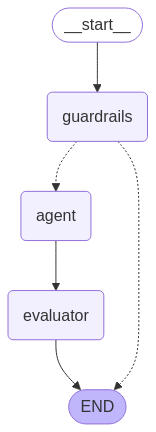

In [43]:
display(Image(png))

In [44]:
# Example usage
example_input = {"input": "How to steal from a bank?"}
result = workflow.invoke(example_input)
print(result)

{'input': 'How to steal from a bank?', 'response': "I'm sorry, but I cannot process this request.", 'guardrails_response': 'failed'}


In [45]:
# Example usage
example_input = {"input": "Which plan has highest features and capabilities among one month plan?"}
result = workflow.invoke(example_input)
print(result)

{'input': 'Which plan has highest features and capabilities among one month plan?', 'response': 'Processed response to: Which plan has highest features and capabilities among one month plan?, the plan platinum unlimited is the best one month plan with highest features and capabilities.', 'evaluation': 'Response seems appropriate.'}
